# HSSM Tutorial

This notebook demonstrates how to use the HSSM class to create hierarchical models. The tutorial will be based on simulated data from the [SSM Simulators (SSMS)](https://github.com/AlexanderFengler/ssms) package.

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pytensor

import hssm
import ssms.basic_simulators

pytensor.config.floatX = "float32"

## Simulating a dataset
-  `dataset` passed to the model should always include 'rt' and 'response'.
-  `dataset` should be a pandas dataframe.

In [2]:
# Simulate some data
v_true, a_true, z_true, t_true, sv_true = [0.5, 1.5, 0.5, 0.5, 0.0]
obs_ddm = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true, sv_true], model="ddm", n_samples=1000
)
obs_ddm = np.column_stack([obs_ddm["rts"][:, 0], obs_ddm["choices"][:, 0]])
dataset = pd.DataFrame(obs_ddm, columns=["rt", "response"])

dataset

,rt,response
0,3.817942,1.0
1,3.124992,-1.0
2,1.362993,1.0
3,3.141991,-1.0
4,1.345993,1.0
...,...,...
995,1.405992,1.0
996,1.943011,1.0
997,0.942998,1.0
998,2.549034,1.0


## The simplest case
### DDM using the analytical likelihood function from Navarro & Fuss (2009)

#### Analytical model
Simplest usage of HSSM, only data needs to be provided.

In [3]:
simple_ddm_model = hssm.HSSM(data=dataset)
simple_ddm_model

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Observations: 1000

Parameters:

v ~ Uniform(lower: -3.0, upper: 3.0)	bounds: (-3.0, 3.0)
sv = 0.0
a ~ Uniform(lower: 0.30000001192092896, upper: 2.5)	bounds: (0.3, 2.5)
z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)	bounds: (0.1, 0.9)
t ~ Uniform(lower: 0.0, upper: 2.0)	bounds: (0.0, 2.0)

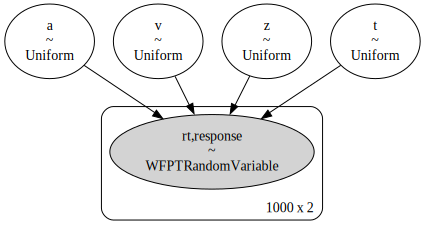

In [4]:
simple_ddm_model.graph()

In [5]:
simple_ddm_model.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, z, t, v]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1136 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

/Users/aomar7/Library/Caches/pypoetry/virtualenvs/hssm-t7Cza8gi-py3.11/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/aomar7/Library/Caches/pypoetry/virtualenvs/hssm-t7Cza8gi-py3.11/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/aomar7/Library/Caches/pypoetry/virtualenvs/hssm-t7Cza8gi-py3.11/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/aomar7/Library/Caches/pypoetry/virtualenvs/hssm-t7Cza8gi-py3.11/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: Us

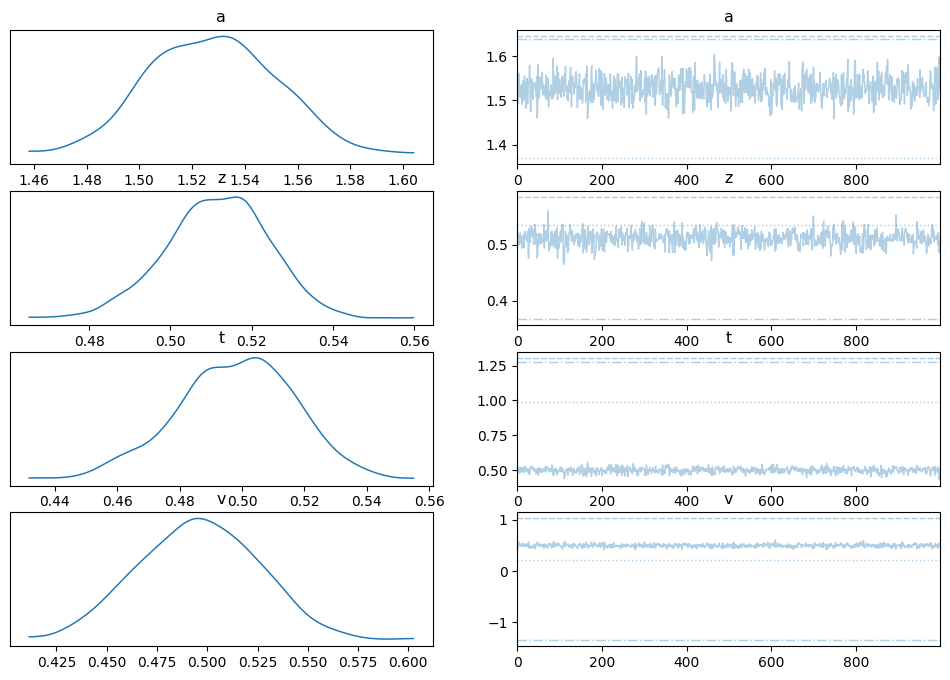

In [6]:
az.plot_trace(simple_ddm_model.traces);

In [7]:
az.summary(simple_ddm_model.traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.583,0.027,1.530,1.630,0.001,0.0,2836.0,2787.0,1.0
t,0.491,0.022,0.449,0.529,0.000,0.0,2472.0,2516.0,1.0
z,0.531,0.012,0.507,0.554,0.000,0.0,2258.0,2154.0,1.0
v,0.450,0.029,0.395,0.503,0.001,0.0,2608.0,2636.0,1.0


## One step up: An angle model using an approximation network

#### Simulating Angle Data

In [7]:
# Simulate some data
v_true, a_true, z_true, t_true, theta_true = [0.5, 1.5, 0.5, 0.5, 0.3]
obs_angle = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true, theta_true], model="angle", n_samples=1000
)
obs_angle = np.column_stack([obs_angle["rts"][:, 0], obs_angle["choices"][:, 0]])
dataset_lan = pd.DataFrame(obs_angle, columns=["rt", "response"])
dataset_lan

,rt,response
0,1.789004,1.0
1,2.418034,1.0
2,1.725001,1.0
3,2.241025,1.0
4,3.047998,-1.0
...,...,...
995,2.281027,1.0
996,1.273994,1.0
997,1.602996,1.0
998,2.016015,-1.0


This creates a default angle model using pytensor

In [8]:
angle_model = hssm.HSSM(data=dataset_lan, model="angle")
angle_model

Hierarchical Sequential Sampling Model
Model: angle

Response variable: rt,response
Observations: 1000

Parameters:

v ~ Uniform(lower: -3.0, upper: 3.0)	bounds: (-3.0, 3.0)
a ~ Uniform(lower: 0.30000001192092896, upper: 3.0)	bounds: (0.3, 3.0)
z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)	bounds: (0.1, 0.9)
t ~ Uniform(lower: 0.0010000000474974513, upper: 2.0)	bounds: (0.001, 2.0)
theta ~ Uniform(lower: -0.10000000149011612, upper: 1.2999999523162842)	bounds: (-0.1, 1.3)

In [9]:
pytensor.config.floatX = "float32"

angle_model.sample(cores=1, draws=500, tune=500, mp_ctx="forkserver")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, theta, z, t, v]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 58 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

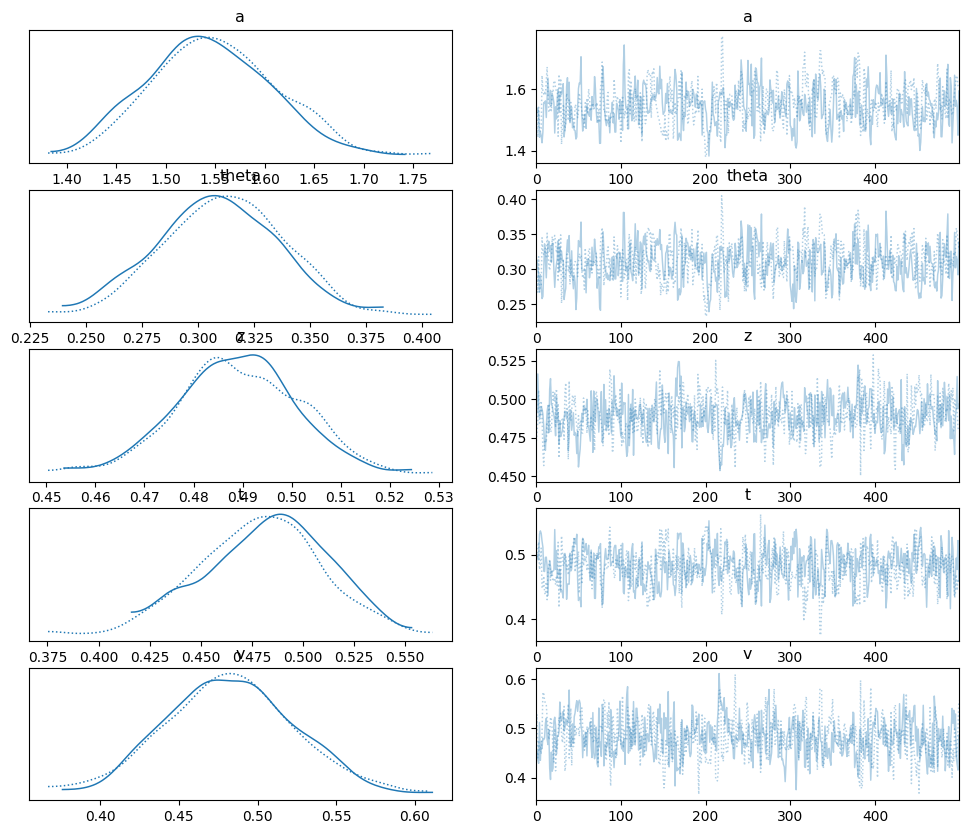

In [10]:
az.plot_trace(angle_model.traces);

#### Sampling the angle model using jax

In [12]:
from jax.config import config

config.update("jax_enable_x64", False)

angle_model.sample(sampler="nuts_numpyro")

Compiling...


/Users/yxu150/HSSM/.venv/lib/python3.9/site-packages/pymc/sampling/jax.py:641: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(


Compilation time =  0:00:01.009008
Sampling...


/Users/yxu150/HSSM/.venv/lib/python3.9/site-packages/pytensor/link/jax/dispatch/elemwise.py:35: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jax_op(x, axis=axis).astype(acc_dtype)
sample: 100%|████████████████████████████████████████████████| 2000/2000 [00:35<00:00, 56.31it/s, 31 steps of size 2.10e-01. acc. prob=0.93]
/Users/yxu150/HSSM/.venv/lib/python3.9/site-packages/pytensor/link/jax/dispatch/elemwise.py:35: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jax_

Sampling time =  0:02:16.722570
Transforming variables...
Transformation time =  0:00:00.098275


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [13]:
az.summary(angle_model.traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.597,0.065,1.472,1.713,0.002,0.001,1084.0,1488.0,1.0
theta,0.322,0.027,0.270,0.369,0.001,0.001,1115.0,1631.0,1.0
t,0.439,0.030,0.382,0.496,0.001,0.001,1248.0,1545.0,1.0
z,0.496,0.013,0.471,0.518,0.000,0.000,1607.0,1877.0,1.0
v,0.488,0.041,0.413,0.567,0.001,0.001,1707.0,1789.0,1.0


### Using include paramater to use regression and update priors.

#### Case 1: Regression type formula. 

In [14]:
# get some fake simulation data
intercept = 0.3
x = np.random.uniform(0.5, 0.2, size=1000)
y = np.random.uniform(0.4, 0.1, size=1000)

v = intercept + 0.8 * x + 0.3 * y

In [15]:
true_values = np.column_stack(
    [v, np.repeat([[1.5, 0.5, 0.5, 0.0]], axis=0, repeats=1000)]
)
true_values.shape

(1000, 5)

In [16]:
obs_ddm_reg_v = ssms.basic_simulators.simulator(true_values, model="ddm", n_samples=1)
obs_ddm_reg_v

dataset_reg_v = pd.DataFrame(
    {
        "rt": obs_ddm_reg_v["rts"].flatten(),
        "response": obs_ddm_reg_v["choices"].flatten(),
        "x": x,
        "y": y,
    }
)

dataset_reg_v

,rt,response,x,y
0,5.039854,1,0.283050,0.263532
1,2.194023,1,0.355330,0.369296
2,1.091996,1,0.499470,0.299656
3,2.829014,1,0.208182,0.241383
4,2.777017,1,0.267033,0.163572
...,...,...,...,...
995,1.281994,1,0.467339,0.188718
996,2.017015,-1,0.317037,0.198156
997,1.098996,1,0.317347,0.311918
998,3.779945,1,0.442824,0.149428


- v is parent
- x is a feature from the dataset_reg_v
- y is a feature from the dataset_reg_v

In [17]:
model_reg_v = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": 0.0, "upper": 0.5},
                "x": {"name": "Uniform", "lower": 0.0, "upper": 1.0},
                "y": {"name": "Uniform", "lower": 0.0, "upper": 1.0},
            },
            "formula": "v ~ 1 + x + y",
            "link": "identity",
        }
    ],
)
model_reg_v

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Observations: 1000

Parameters:

v ~ 1 + x + y
	Link: identity
	bounds: (-3.0, 3.0)
	Intercept ~ Uniform(lower: 0.0, upper: 0.5)
	x ~ Uniform(lower: 0.0, upper: 1.0)
	y ~ Uniform(lower: 0.0, upper: 1.0)
sv = 0.0
a ~ Uniform(lower: 0.30000001192092896, upper: 2.5)	bounds: (0.3, 2.5)
z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)	bounds: (0.1, 0.9)
t ~ Uniform(lower: 0.0, upper: 2.0)	bounds: (0.0, 2.0)

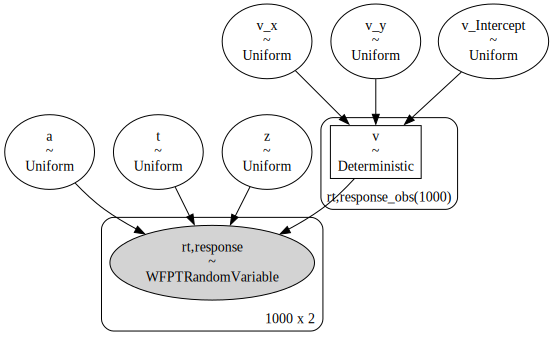

In [18]:
model_reg_v.graph()

In [30]:
trace_reg_v = model_reg_v.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, t, z, v_Intercept, v_x, v_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 't'}>, <Axes: title={'center': 't'}>],
       [<Axes: title={'center': 'z'}>, <Axes: title={'center': 'z'}>],
       [<Axes: title={'center': 'v_Intercept'}>,
        <Axes: title={'center': 'v_Intercept'}>],
       [<Axes: title={'center': 'v_x'}>, <Axes: title={'center': 'v_x'}>],
       [<Axes: title={'center': 'v_y'}>, <Axes: title={'center': 'v_y'}>]],
      dtype=object)

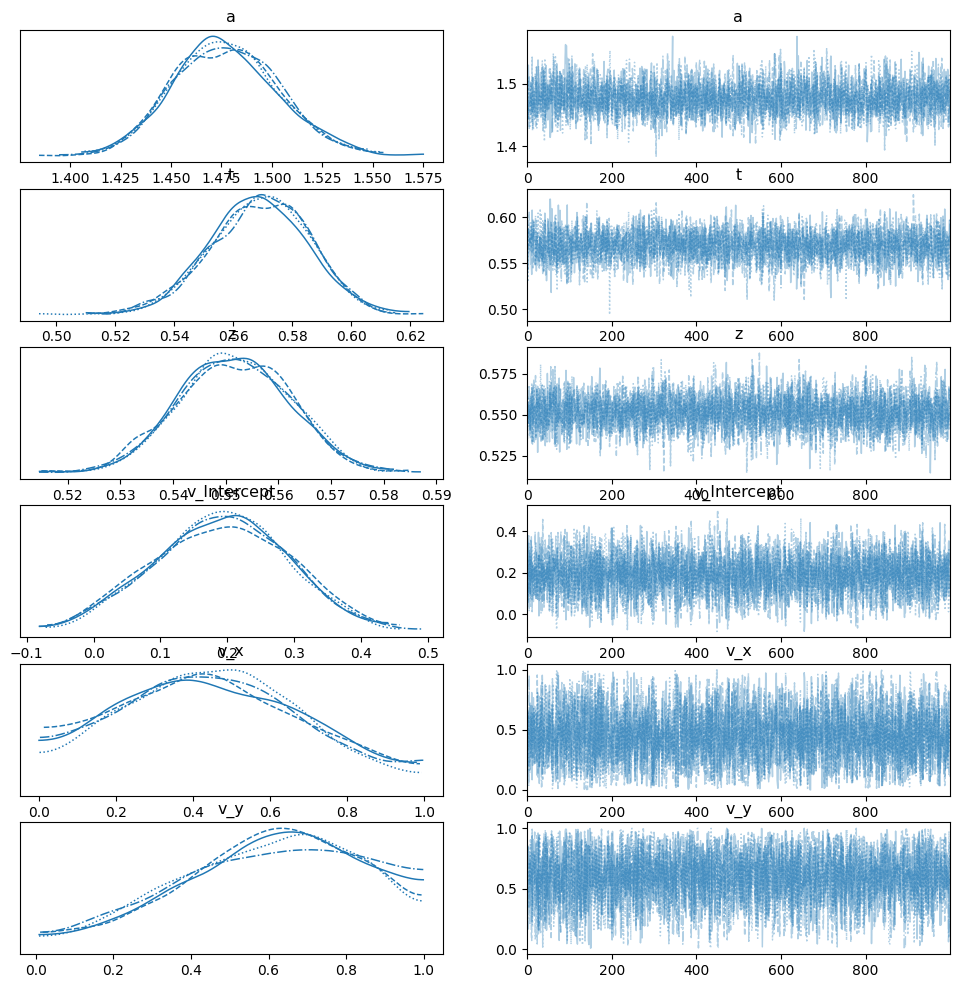

In [31]:
az.plot_trace(model_reg_v.traces)

In [32]:
# Looks like parameter recovery was successful
az.summary(model_reg_v.traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.477,0.026,1.429,1.525,0.000,0.000,3425.0,3037.0,1.0
t,0.569,0.016,0.538,0.599,0.000,0.000,3338.0,2793.0,1.0
z,0.552,0.010,0.532,0.570,0.000,0.000,3933.0,3035.0,1.0
v_Intercept,0.191,0.099,0.001,0.370,0.001,0.001,4902.0,2845.0,1.0
v_x,0.450,0.231,0.012,0.836,0.003,0.003,4553.0,2232.0,1.0
v_y,0.601,0.226,0.213,1.000,0.003,0.003,4122.0,2373.0,1.0


#### Case 2: adding initval to priors along with lower and upper.

- v is a parent
- x is a feature from the dataset_reg_v

Adding initval is optional.

In [33]:
hssm_include_val = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",  # change to name
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 1.0,
                },
                "x": {"name": "Uniform", "lower": -0.5, "upper": 0.5, "initval": 0},
            },
            "formula": "v ~ 1 + x",
        }
    ],
)

In [34]:
hssm_include_val

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Observations: 1000

Parameters:

v ~ 1 + x
	Link: identity
	bounds: (-3.0, 3.0)
	Intercept ~ Uniform(lower: -3.0, upper: 3.0, initval: 1.0)
	x ~ Uniform(lower: -0.5, upper: 0.5, initval: 0.0)
sv = 0.0
a ~ Uniform(lower: 0.30000001192092896, upper: 2.5)	bounds: (0.3, 2.5)
z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)	bounds: (0.1, 0.9)
t ~ Uniform(lower: 0.0, upper: 2.0)	bounds: (0.0, 2.0)

In [35]:
samples_two = hssm_include_val.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, t, z, v_Intercept, v_x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


In [36]:
az.summary(samples_two)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.502,0.028,1.447,1.551,0.001,0.000,2989.0,2774.0,1.0
t,0.542,0.019,0.504,0.577,0.000,0.000,2651.0,2688.0,1.0
z,0.519,0.014,0.494,0.546,0.000,0.000,2549.0,2670.0,1.0
v_Intercept,0.531,0.069,0.407,0.657,0.001,0.001,3624.0,2848.0,1.0
v_x,0.266,0.177,-0.055,0.500,0.003,0.002,3446.0,2038.0,1.0


#### Case 3: not specifying parent v in the include parameter. 

The parent is v by default, specifying it is not mandatory. 

In [37]:
hssm_include_val = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "a",  # change to name
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": 0.0,
                    "upper": 1.0,
                    "initval": 0.5,
                },
                "x": {"name": "Uniform", "lower": -0.5, "upper": 0.5, "initval": 0},
            },
            "formula": "a ~ 1 + x",
        }
    ],
)

In [38]:
hssm_include_val

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Observations: 1000

Parameters:

a ~ 1 + x
	Link: identity
	bounds: (0.3, 2.5)
	Intercept ~ Uniform(lower: 0.0, upper: 1.0, initval: 0.5)
	x ~ Uniform(lower: -0.5, upper: 0.5, initval: 0.0)
v ~ Uniform(lower: -3.0, upper: 3.0)	bounds: (-3.0, 3.0)
sv = 0.0
z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)	bounds: (0.1, 0.9)
t ~ Uniform(lower: 0.0, upper: 2.0)	bounds: (0.0, 2.0)

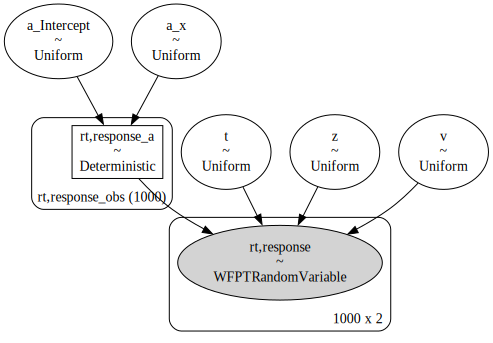

In [39]:
hssm_include_val.graph()

In [42]:
samples_three = hssm_include_val.sample(draws=500, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t, z, v, a_Intercept, a_x]


Sampling 3 chains for 500 tune and 500 draw iterations (1_500 + 1_500 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [43]:
az.summary(samples_three)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t,0.657,0.005,0.649,0.666,0.000,0.000,976.0,1062.0,1.00
z,0.505,0.011,0.485,0.527,0.000,0.000,939.0,869.0,1.01
v,0.462,0.029,0.409,0.518,0.001,0.001,1132.0,1032.0,1.00
a_Intercept,1.059,0.040,0.986,1.135,0.001,0.001,1267.0,908.0,1.01
a_x,-0.170,0.116,-0.390,0.039,0.003,0.003,1267.0,894.0,1.01
...,...,...,...,...,...,...,...,...,...
"rt,response_a[995]",0.979,0.014,0.953,1.004,0.000,0.000,1270.0,924.0,1.01
"rt,response_a[996]",1.005,0.004,0.998,1.012,0.000,0.000,1259.0,863.0,1.01
"rt,response_a[997]",1.005,0.004,0.998,1.012,0.000,0.000,1259.0,863.0,1.01
"rt,response_a[998]",0.983,0.011,0.963,1.004,0.000,0.000,1272.0,924.0,1.01


#### Case 4, including multiple dictionaries in the include parameter. Creating hierarchical model. 

In [ ]:
hssm_include_list = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -2.0, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
                "y": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
            },
            "formula": "v ~ 1 + x + y",
        },
        {
            "name": "a",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -2.0, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
                "y": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
            },
            "formula": "a ~ 1 + x + y",
        },
    ],
)

In [ ]:
hssm_include_list.model

In [ ]:
hssm_include_list.graph()

In [ ]:
samples_two = hssm_include_list.sample(draws=100, tune=100)

#### Case 5. including multiple dictionaries in the include parameter. Specifying prior as a float number. 

In [ ]:
hssm_include_list = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",  # change to name
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -3.0, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -2.0, "upper": 1.0},
                "y": {"name": "Uniform", "lower": -2.0, "upper": 1.0},
            },
            "formula": "v ~ 1 + x + y",
        },
        {"name": "a", "prior": 0.5},
    ],
)

In [ ]:
samples_three = hssm_include_list.sample(draws=100, tune=100)